# Plot Galsim PSF with fixed parameters (optics + atmosph.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
mpl.rcParams["font.size"] = 16
mpl.rcParams['axes.titlesize'] = 16
plt.rcParams['image.cmap'] = 'RdBu_r'

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [3]:
from types import SimpleNamespace
import multiprocessing
import time
import regex as re
import glob
import json
import yaml
import random

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift

import galsim
from model import *

In [16]:
def get_Obs_PSF(
    lam_over_diam,
    opt_defocus,
    opt_c1,
    opt_c2,
    opt_a1,
    opt_a2,
    opt_obscuration,
    atmos_fwhm,
    atmos_e,
    atmos_beta,
    spher,
    trefoil1,
    trefoil2,
    g1_err=0,
    g2_err=0,
    fov_pixels=48,
    pixel_scale=0.03,
    upsample=4,
    skip_atmos=False
):
    """Simulate a PSF from a ground-based observation. The PSF consists of an optical component and an atmospheric component.

    Args:
        lam_over_diam (float): Wavelength over diameter of the telescope.
        opt_defocus (float): Defocus in units of incident light wavelength.
        opt_c1 (float): Coma along y in units of incident light wavelength.
        opt_c2 (float): Coma along x in units of incident light wavelength.
        opt_a1 (float): Astigmatism (like e2) in units of incident light wavelength.
        opt_a2 (float): Astigmatism (like e1) in units of incident light wavelength.
        opt_obscuration (float): Linear dimension of central obscuration as fraction of pupil linear dimension, [0., 1.).
        atmos_fwhm (float): The full width at half maximum of the Kolmogorov function for atmospheric PSF.
        atmos_e (float): Ellipticity of the shear to apply to the atmospheric component.
        atmos_beta (float): Position angle (in radians) of the shear to apply to the atmospheric component, twice the phase of a complex valued shear.
        spher (float): Spherical aberration in units of incident light wavelength.
        trefoil1 (float): Trefoil along y axis in units of incident light wavelength.
        trefoil2 (float): Trefoil along x axis in units of incident light wavelength.
        g1_err (float, optional): The first component of extra shear applied to the overall PSF to simulated a erroneously estimated PSF. Defaults to `0`.
        g2_err (float, optional): The second component of extra shear applied to the overall PSF to simulated a erroneously estimated PSF. Defaults to `0`.
        fov_pixels (int, optional): Width of the simulated images in pixels. Defaults to `48`.
        pixel_scale (float, optional): Pixel scale of the simulated image determining the resolution. Defaults to `0.2`.
        upsample (int, optional): Upsampling factor for the PSF image. Defaults to `4`.

    Returns:
        `torch.Tensor`: Simulated PSF image with shape `(fov_pixels*upsample, fov_pixels*upsample)`.
    """

    # Atmospheric PSF
    atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
    atmos = atmos.shear(e=atmos_e, beta=atmos_beta * galsim.radians)

    # Optical PSF
    optics = galsim.OpticalPSF(
        lam_over_diam,
        defocus=opt_defocus,
        coma1=opt_c1,
        coma2=opt_c2,
        astig1=opt_a1,
        astig2=opt_a2,
        spher=spher,
        trefoil1=trefoil1,
        trefoil2=trefoil2,
        obscuration=opt_obscuration,
        flux=1,
    )

    # Convolve the two components.
    if skip_atmos:
        psf=optics
    else:
        psf = galsim.Convolve([atmos, optics])

    # Shear the overall PSF to simulate a erroneously estimated PSF when necessary.
    psf = psf.shear(g1=g1_err, g2=g2_err)

    # Draw PSF images.
    psf_image = galsim.ImageF(fov_pixels * upsample, fov_pixels * upsample)
    psf.drawImage(psf_image, scale=pixel_scale / upsample, method="auto")
    psf_image = torch.from_numpy(psf_image.array)

    return psf_image

In [17]:
def crop_center(arr, npix=64):
    return arr[arr.shape[0]//2-npix//2:arr.shape[0]//2+npix//2,
        arr.shape[1]//2-npix//2:arr.shape[1]//2+npix//2]

In [18]:
def format_float_values(obj):
    if isinstance(obj, float):
        return round(obj, 3)
    elif isinstance(obj, dict):
        return {k: format_float_values(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [format_float_values(item) for item in obj]
    else:
        return obj

In [45]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"

with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [46]:
# default values used for optical and other params EXCEPT atmosperic fwhm

#optics 1
args.lam_over_diam= 0.024
args.opt_defocus = -0.072
args.opt_c1 = 0.177
args.opt_c2 = -0.027
args.opt_a1 = 0.016
args.opt_a2 = 0.005
args.opt_obscuration = 0.111
args.spher = 0.056
args.trefoil1 = 0.028
args.trefoil2 = 0.001
#Kolmogorov (non FWHM)
args.atmos_e = 0.021
args.atmos_beta = 0.276



# Galaxy 
args.gal_g = 0.02 # Shear
args.gal_beta = 0. # Shear
args.gal_mu = 1.0 # Magnification
args.gal_theta = 0.0 # rotation
args.gal_dx = 0.0     # dx
args.gal_dy = 0.0     #dx

In [51]:
#atmos_fwhm <=0.01 has practically no effect
fwhm_range = np.array([0.0001, 0.05, 0.2 , 0.4])
psf_optics_atm_all=[]

for atmos_fwhm in fwhm_range:
    psf_optics_atm_all.append(get_Obs_PSF(
        lam_over_diam=args.lam_over_diam,
        opt_defocus=args.opt_defocus,
        opt_c1=args.opt_c1,
        opt_c2=args.opt_c2,
        opt_a1=args.opt_a1,
        opt_a2=args.opt_a2,
        opt_obscuration=args.opt_obscuration,
        spher=args.spher,
        trefoil1=args.trefoil1,
        trefoil2=args.trefoil2,
        atmos_fwhm=atmos_fwhm,
        atmos_e=args.atmos_e,
        atmos_beta=args.atmos_beta,
        skip_atmos=False))

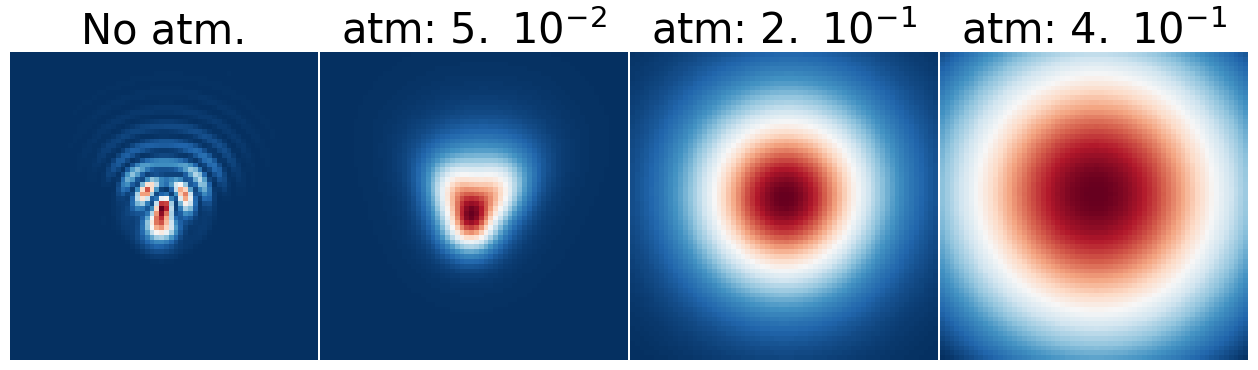

In [66]:
ncol = len(fwhm_range)
fig, axs = plt.subplots(1, ncol, figsize=(4*ncol, 4))
for i, atmos_fwhm in enumerate(fwhm_range):
    axs[i].imshow(crop_center(psf_optics_atm_all[i].cpu().squeeze()))
    axs[i].axis("off")
    if i==0:
        axs[0].set_title("No atm.",fontsize=30)
    else:
        scientific_notation = f"{atmos_fwhm:.1e}"  # "4.0e-01"
        base, exponent = scientific_notation.split('e')
        exponent = int(exponent)
        base = base.replace('.', '')[:1]  # "4"
        latex_notation = f"${base}.\  10^{{{exponent}}}$"
        axs[i].set_title(f"atm: {latex_notation}",fontsize=30)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("psf_atm_exemple.pdf",bbox_inches='tight', pad_inches=0.2)